## 栅格转矢量

In [1]:
from osgeo import gdal, ogr
import matplotlib.pyplot as plt

In [3]:
path_mndwi = "E:/YNU/5/OpenSourceGIS/Act_5/OnClass/呈贡10m分辨率裁剪子区域及呈贡20m分辨率/chenggong_utm48_20m_mndwi.tif"
dset = gdal.Open(path_mndwi)
mndwi = dset.GetRasterBand(1)
mndwi_array = mndwi.ReadAsArray()
print(mndwi_array.shape)

(1613, 1499)


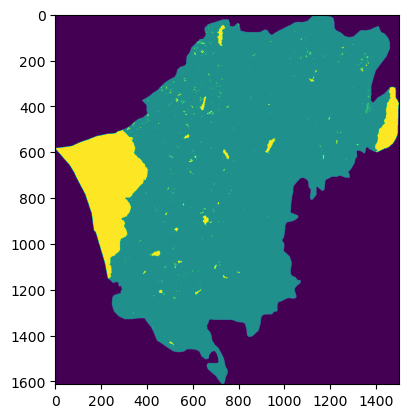

In [4]:
plt.imshow(mndwi_array)

In [5]:
path_mndwi2polygon = 'E:/YNU/5/OpenSourceGIS/Act_5/OnClass/栅格转矢量/chenggong_utm48_20m_mndwi_thre01_vec.gpkg'

proj = gdal.osr.SpatialReference()
proj.ImportFromWkt(dset.GetProjection())

driver_vec = ogr.GetDriverByName('GPKG')
ds_vec = driver_vec.CreateDataSource(path_mndwi2polygon)
poly_layer = ds_vec.CreateLayer('mndwi_polygon', srs=proj, geom_type=ogr.wkbMultiPolygon)
Field_DN = ogr.FieldDefn('DN', ogr.OFTInteger)
poly_layer.CreateField(Field_DN)
gdal.Polygonize(srcBand=mndwi, maskBand=None, outLayer=poly_layer, iPixValField=0)

DN_vec = [1]
for fea in poly_layer:
    DN_value = fea.GetField('DN')
    if DN_value not in DN_vec:
        poly_layer.DeleteFeature(fea.GetFID())

ds_vec = None
dset = None

## 矢量转栅格

In [12]:
path_vec ='E:/YNU/5/OpenSourceGIS/Act_5/OnClass/栅格转矢量/chenggong_utm48_20m_mndwi_thre01_vec.gpkg'
path_raster='E:/YNU/5/OpenSourceGIS/Act_5/OnClass/矢量转栅格/chenggong_utm48_20m_mndwi_thre01_vecZraster.tif'

In [13]:
ds_vec = ogr.Open(path_vec)
layer_vec = ds_vec.GetLayer()
proj_vec = layer_vec.GetSpatialRef()
proj_vec_wkt = proj_vec.ExportToWkt()
print(proj_vec_wkt)

x_min, x_max,y_min, y_max = layer_vec.GetExtent()
print(x_min, x_max, y_min, y_max)

PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32648"]]
268162.23598 298142.23598 2733198.41548797 2765458.41548797


In [17]:
pixel_size = 20
geo_trans =[x_min, 20, 0, y_max, 0, -20]
x_size = int((x_max-x_min)/pixel_size)
y_size = int((y_max-y_min)/pixel_size)

driver = gdal.GetDriverByName('GTiff')
dset_raster = driver.Create(path_raster,
                            xsize=x_size,
                            ysize=y_size,
                            bands=1,
                            eType=gdal.GDT_Int16
                            )

dset_raster.SetGeoTransform(geo_trans)
dset_raster.SetProjection(proj_vec_wkt)

0

In [18]:
gdal.RasterizeLayer(dataset=dset_raster, bands=[1], layer=layer_vec, options=['ATTRIBUTE=DN'])

dset_raster = None